# HW4
## Eren Tumkaya - 090190328

## Overall Rules

- Do not upload data files with your homework since the datasets are large and already available as a library. 
- Document all of your steps by writing appropriate markdown cells in your notebook. Refrain from using code comments to explain what has been done.
- Avoid duplicating code. Do not copy and paste code from one cell to another. If copying and pasting is necessary, write a suitable function for the task at hand and call that function.
- Document your use of LLMs (ChatGPT, Claude, Code Pilot etc). Either take screenshots of your steps and include them with this notebook, or give me a full log (both questions and answers) in a markdown file named HW4-LLM-LOG.md.

Failure to adhere to these guidelines will result in a 25-point deduction for each infraction.

## The Datasets

In this homework, we are going to use the MNIST dataset and Olivetti Faces datasets.

## The Task

Your task is to find the best supervised machine learning algorithm that predicts the target variables from the independent variables. You must test **all** of the supervised classification algorithms we learned in this class on both datasets. 

In doing your experiments please pay attention to the following issues:

- In train-test-split phase, you must use an appropriate stratification method. 
- In testing the algorithms, you must use an appropriate cross-validation method that gives accuracy/precision/recall with a confidence interval. Do not trust the default setting on cross-validation functions. Find the correct way of stratifying the dataset.
- In testing the ensemble algorithms, you must test both ensemble schemes (one-vs-one and one-vs-rest) in your cross-validation methods.
- In testing all algorithms, record how long it takes to run the experiment.

Do your experiments, and display your results (accuracy/precision/recall/runtime with the confidence intervals) as a table. Decide which algorithm is your choice for each dataset. Write a detailed analysis of the results displayed in the table. In your analyses, I would like to see why you have chosen *your best model*.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.datasets import load_digits
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import time
from keras.optimizers import Adam
from sklearn.datasets import load_digits, fetch_olivetti_faces



## Getting to Know the Datasets

The very first thing to state about the two datasets is the fact that they are both quite balanced in terms of their class distributions. I will take a closer look at the digits dataset now.

### MNIST 

In [3]:
mnist=load_digits()

In [4]:
mnist.data.shape

(1797, 64)

In [5]:
mnist.target.shape

(1797,)

In [6]:
np.unique(mnist.target.astype(int))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [7]:
pd.Series(mnist.target).value_counts().sort_index()

0    178
1    182
2    177
3    183
4    181
5    182
6    181
7    179
8    174
9    180
Name: count, dtype: int64

It is good that I have almost evenly distributed classes. I will take a look at some example images now.

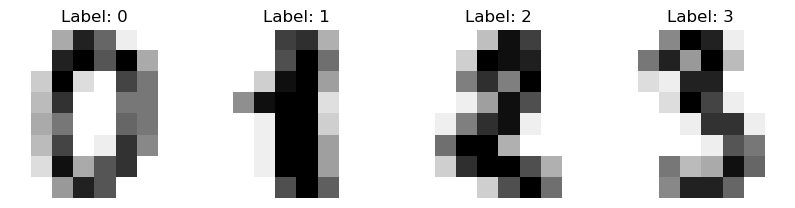

In [11]:




fig, axes = plt.subplots(1, 4, figsize=(10, 3))
for ax, image, label in zip(axes, mnist.images, mnist.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Label: %i' % label)
plt.show()

### Olivetti Faces Dataset

I will do the same checks to the dataset just like I did for the the digits one.

In [9]:
faces=fetch_olivetti_faces()
faces.data.shape

(400, 4096)

In [10]:
faces.target.shape

(400,)

This time let's see some images of the first person(class).

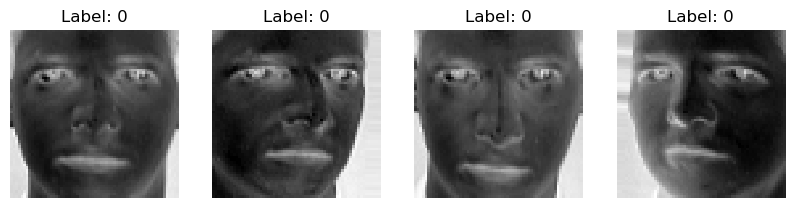

In [12]:


fig, axes = plt.subplots(1, 4, figsize=(10, 3))
for ax, image, label in zip(axes, faces.images, faces.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Label: %i' % label)
plt.show()

## Writing the Code

As usual, the first thing I did was to write the necessary functions. Since I have two datasets which I want to test, I thought it would be better to write one function to handle both tasks. My main function is "classify_with_strategy". It inputs the model I want to try, the strategy (onevsone, onevsrest), the test size, the number of iterations to perform validation multiple times (It was necessary to obtain confidence intervals instead of a number for the metrics) and I also added whether the data should be scaled or not. 

### Train-Test split with Stratification

Both sets have many classes for their targets and I wanted to ensure each of them had the same probability of being in the test sets. I believe this was the correct way to fit the model and also ensure it's validation. I can conclude by saying that I needed to perform that in order to maintain the correct propotion of the classes in the real set.

### Validation Method and Creating Confidence Intervals

I wanted to perform the training with randomly selected different subsets chosen with the help of stratification. I calculated the accuracy, precision average and the recall average each iteration. Afterwards I wrote a funcion called bootstrap_confidence_interval" to perform bootstraping on the metrics which gave me the confidence intervals for alpha=0.05.  

One thing to note here, I could have also calculated the precision and recall for each classes seperatly and give confidence intervals. However, considering the digits dataset has 10 classes moreover, the faces one has 40 made me thing that it would be almost impossible to correctly interpret the values that way. That is why I took the averages for them each iteration.

### Bootstraping as a Way of Creating CI's

I didn't want to perform k-fold validation since it gives less info on the effects of the variation and, like I mentioned, I wanted to create confidence intervals. To be able to use the same method in all three metrics, my chosen method was bootstraping. I am aware of the fact that it would be better if I trained the model with more iterations but due to time it takes, I choose to train 10 times. I set the number of bootstraping samples to 100.

### Additional Handling of Neural Networks

I was going to train all classification algorithms with both strategies: onevsone and onevsrest. However, for neural networks I didn't have a parameter like that. I needed to handle the strategy and also the proccesing in neural network in a different manner. Hence, I wrote a function to train neural networks in a different way.

### Training and Prediction Times

I wanted to see how long it takes to train the models since it can also be important in evaluating the models. Later, I also added the prediction time measure because for some models, such as knn models, there is no need for training and I need to see the prediction time to correctly asses model.  

In [44]:
def create_neural_network(input_dim, output_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def bootstrap_confidence_interval(data, num_bootstrap_samples=100, alpha=0.05):
    bootstrap_samples = []
    for _ in range(num_bootstrap_samples):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_samples.append(np.mean(bootstrap_sample))
    lower_percentile = 100 * alpha / 2
    upper_percentile = 100 * (1 - alpha / 2)
    lower_bound = np.percentile(bootstrap_samples, lower_percentile)
    upper_bound = np.percentile(bootstrap_samples, upper_percentile)
    return lower_bound, upper_bound

def classify_with_strategy(model, strategy, dataset, test_size, iterations=5, random_state=42, scale_data=False):
    if dataset == 'mnist':
        data = load_digits()
    elif dataset == 'faces':
        data = fetch_olivetti_faces()
    else:
        raise ValueError("Invalid dataset. Choose either 'mnist' or 'faces'.")

    input_dim = data.data.shape[1]
    output_dim = len(np.unique(data.target))
    accuracies = []
    precisions = []
    recalls = []
    train_times = []
    prediction_times = []

    for i in range(iterations):
        X_train, X_test, y_train, y_test = train_test_split(
            data.data, data.target, test_size=test_size, random_state=random_state+i, stratify=data.target)

        if scale_data:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

        start_train_time = time.time()

        if isinstance(model, Sequential):
            clf = create_neural_network(input_dim, output_dim)
            clf.fit(X_train, y_train, epochs=15, batch_size=32, verbose=0)
        else:
            if strategy == 'onevsone':
                clf = OneVsOneClassifier(model)
            elif strategy == 'onevsrest':
                clf = OneVsRestClassifier(model)
            elif strategy is None:
                clf = model
            else:
                raise ValueError("Invalid strategy. Choose either 'onevsone', 'onevsrest', or None for neural networks.")
            clf.fit(X_train, y_train)

        end_train_time = time.time()
        train_times.append(end_train_time - start_train_time)

        start_prediction_time = time.time()

        if isinstance(model, Sequential):
            y_pred = np.argmax(clf.predict(X_test), axis=1)
        else:
            y_pred = clf.predict(X_test)

        end_prediction_time = time.time()
        prediction_times.append(end_prediction_time - start_prediction_time)

        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred, average='weighted'))
        recalls.append(recall_score(y_test, y_pred, average='weighted'))

    accuracy_ci = bootstrap_confidence_interval(accuracies)
    precision_ci = bootstrap_confidence_interval(precisions)
    recall_ci = bootstrap_confidence_interval(recalls)
    mean_train_time = np.mean(train_times)
    mean_prediction_time = np.mean(prediction_times)
    accuracy_ci = np.round(accuracy_ci, 3)
    precision_ci = np.round(precision_ci, 3)
    recall_ci = np.round(recall_ci, 3)
    mean_train_time = round(mean_train_time, 3)
    mean_prediction_time = round(mean_prediction_time, 3)
    return accuracy_ci, precision_ci, recall_ci, mean_train_time, mean_prediction_time

## Model Selection

After I completed writing the function, I wanted to select all the models which can be used in modeling for these two classification tasks. I included 10 different ML algorithms and the total number hit 13 with all the variations of theirs. 

In [37]:

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM_linear': SVC(kernel='linear'),
    'SVM_poly': SVC(kernel='poly'),
    'SVM_rbf': SVC(kernel='rbf'),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'KNN_euclidean': KNeighborsClassifier(metric='euclidean'),
    'KNN_manhattan': KNeighborsClassifier(metric='manhattan'),
    'XGBoost': xgb.XGBClassifier(),
    'LightGBM': lgb.LGBMClassifier(),
    'LDA': LinearDiscriminantAnalysis(),
    'Neural Network': Sequential()
}

## Evaluating the Models for Both Dataset

Lastly, I wrote the "evaluate_models" function in order to be able to easily try the main function for both of the dataset. It inputs which data I want to model, the test size, number of iterations and also whether I want the data to be scaled or not.   

It returns the comparision table with all the features which will be important for me to asses the models.

In [35]:
def load_dataset(dataset_name):
    if dataset_name == 'mnist':
        return load_digits()
    elif dataset_name == 'faces':
        return fetch_olivetti_faces()
    else:
        raise ValueError("Invalid dataset. Choose either 'mnist' or 'faces'.")

def evaluate_models(models, dataset_name, test_size=0.2, iterations=10, scale_data=True):
    results = []
    dataset = load_dataset(dataset_name)
    for model_name, model in models.items():
        for strategy in ['onevsone', 'onevsrest', None]:
            if strategy is None and model_name != 'Neural Network':
                continue
            if strategy in ['onevsone', 'onevsrest'] and model_name == 'Neural Network':
                continue
            if model_name == 'Neural Network' and strategy is None:
                accuracy_ci, precision_ci, recall_ci, mean_train_time, mean_prediction_time = classify_with_strategy(
                    model, strategy, dataset_name, test_size=test_size, iterations=iterations, scale_data=scale_data)
                results.append({
                    'Model': model_name,
                    'Accuracy CI': accuracy_ci,
                    'Precision CI': precision_ci,
                    'Recall CI': recall_ci,
                    'Mean Train Time': mean_train_time,
                    'Mean Prediction Time': mean_prediction_time
                })
                break
            accuracy_ci, precision_ci, recall_ci, mean_train_time, mean_prediction_time = classify_with_strategy(
                model, strategy, dataset_name, test_size=test_size, iterations=iterations, scale_data=scale_data)
            results.append({
                'Model': model_name,
                'Strategy': strategy,
                'Accuracy CI': accuracy_ci,
                'Precision CI': precision_ci,
                'Recall CI': recall_ci,
                'Mean Train Time': mean_train_time,
                'Mean Prediction Time': mean_prediction_time
            })
    return results




## Mnist Dataset - Modeling

Let's evaluate the models for the mnist data. I will use the function I wrote earlier. I wanted to use the test size as 0.2 and perform 10 iterations.

In [ ]:
mnist = evaluate_models(models, dataset_name='mnist', test_size=0.2, iterations=10, scale_data=True)

In [46]:
pd.DataFrame(mnist)

,Model,Strategy,Accuracy CI,Precision CI,Recall CI,Mean Train Time,Mean Prediction Time
0,Logistic Regression,onevsone,"[0.98, 0.986]","[0.981, 0.986]","[0.98, 0.986]",0.216,0.011
1,Logistic Regression,onevsrest,"[0.962, 0.972]","[0.962, 0.973]","[0.963, 0.972]",0.104,0.001
2,SVM_linear,onevsone,"[0.976, 0.982]","[0.976, 0.982]","[0.977, 0.981]",0.063,0.042
3,SVM_linear,onevsrest,"[0.945, 0.959]","[0.945, 0.959]","[0.944, 0.958]",0.122,0.009
4,SVM_poly,onevsone,"[0.966, 0.975]","[0.971, 0.978]","[0.965, 0.975]",0.104,0.147
5,SVM_poly,onevsrest,"[0.979, 0.982]","[0.98, 0.983]","[0.979, 0.983]",0.222,0.042
6,SVM_rbf,onevsone,"[0.976, 0.984]","[0.977, 0.984]","[0.976, 0.984]",0.099,0.293
7,SVM_rbf,onevsrest,"[0.973, 0.982]","[0.974, 0.983]","[0.974, 0.981]",0.153,0.074
8,Decision Tree,onevsone,"[0.895, 0.914]","[0.901, 0.918]","[0.897, 0.915]",0.095,0.015
9,Decision Tree,onevsrest,"[0.815, 0.838]","[0.864, 0.883]","[0.816, 0.84]",0.109,0.002


### Analysis of the Results for Mnist - Digits Dataset

Almost all models performed somewhat well in assigning the correct labels. All the metrics have confidence intervals which can be counted as quite good.  

1) Decision tree is the worst performing model by far with the onevsrest strategy being the lowest accurate, precise and recalling model. I believe they were poorly affected by the dimension. The ensemble models using decision trees did fairly well in terms of the metric confidence intervals however, it is worthy to mention they took a lot more time. 

2) Logistic Regression with "onevsone" strategy was the undisputed best performing model for all metrics. Mean training time took one fifth of a second which shows that it trained faster than the most. As expected, onevsone strategy took around twice more to train than the onevsrest.  

3) SVC with polynomial kernel using "onevsrest" strategy also showed remarkable results. 

4) K-NN with both metrics and both strategies took so much time in their prediction phase. I believe I should compare it with other model's training times since it doesn't train, it only predicts each value by calculating the distances between the value and all other values in the training set given the metric. Well, euclidian metric with "onevsone" strategy was the leading time consumer in the table. It took more than 15 seconds on average. Manhattan metric and other strategies also took much more than the others.   

5) Random Forest, Gradient Boosting, Adaboost took much more time compared to simpler ones like svm and lr. However, one can't quite say that they did better.

6) Neural Network model did well and actually it took less time than the ensemble methods. I couldve changed the layer count and size and probably it would result in a higher time complexity.




### Best Model for the Mnist - Digits Dataset (Opinion)

I would go between Logistic Regresion(onevsone) and SVC(onevsone) with linear kernel due to their high performance on all three metrics and fast training. As we also learned in class, if we can get good results with these relatively simpler and traditional models, we should stick to them. LR had a bit better results on all metrics, however SVC was trained 3 times faster. 

If I have to choose only one, I would definietly go with Logistic Regression("onevsone").  Aside from the minimal performance improvement, I think it is critical that Logistic Regression is an easily inpretable model wheras SVM's are know for being black boxes. This plays a cruical role in understanding the model, feature importances. I would be quite happy to fastly obtain quite good results along with having deep knowledge of the effects of the variables. Well, I know that my features are pixels in this case, and interpreting each might not be as straightforward as a typical numerical feature however, one might be interested in finding out which parts of the images contribute the most to effectively classifying the target.



## Olivetti Faces Dataset - Modeling

The dataset has 40 classes. For each class it has 10 photos. That basically means that when I do the stratification by the target values, I will have only two test samples for each class if I split the dataset 0.8 to 0.2. For that reason, I wanted to use a test set size which equals to 0.4. I am going to perform the iteration 10 times. 

In [ ]:
faces = evaluate_models(models, dataset_name='faces', test_size=0.4, iterations=10, scale_data=True)

In [48]:
pd.DataFrame(faces)

,Model,Strategy,Accuracy CI,Precision CI,Recall CI,Mean Train Time,Mean Prediction Time
0,Logistic Regression,onevsone,"[0.944, 0.96]","[0.958, 0.968]","[0.946, 0.959]",42.512,8.078
1,Logistic Regression,onevsrest,"[0.959, 0.969]","[0.967, 0.977]","[0.96, 0.97]",8.895,0.224
2,SVM_linear,onevsone,"[0.95, 0.968]","[0.962, 0.973]","[0.949, 0.966]",2.999,15.751
3,SVM_linear,onevsrest,"[0.962, 0.973]","[0.972, 0.98]","[0.962, 0.972]",1.816,0.806
4,SVM_poly,onevsone,"[0.692, 0.744]","[0.826, 0.873]","[0.694, 0.736]",3.162,17.737
5,SVM_poly,onevsrest,"[0.913, 0.936]","[0.929, 0.951]","[0.914, 0.933]",5.355,2.417
6,SVM_rbf,onevsone,"[0.917, 0.937]","[0.935, 0.949]","[0.917, 0.937]",3.226,45.195
7,SVM_rbf,onevsrest,"[0.94, 0.959]","[0.952, 0.967]","[0.941, 0.957]",2.559,4.102
8,Decision Tree,onevsone,"[0.805, 0.84]","[0.856, 0.883]","[0.804, 0.84]",20.873,1.363
9,Decision Tree,onevsrest,"[0.371, 0.403]","[0.512, 0.543]","[0.368, 0.4]",24.675,0.037


### Analysis of the Results for Olivetti Faces Dataset

As I have already showed in the beginning, this dataset has an important shape worth mentioning: It has 400 rows and 4096 columns. Since it indicates a really high dimensional dataset, especially compared to the digits one, I was quite excited to see which model would perform well. Before talking about the models, I think it is important to mention that this code took almost 12 hours to run. 
1) Firstly, I want to talk about the XGboost and LightGbm. They performed so poorly for all metrics and in all strategies. I believe these powerful models need so much data points to be trained well, and in a shape where there is 400 rows(If we take the fact that I only used 60 percent of the dataset to train = 240 into account, it is even worse) they cant distinguish the classes well especially in quite high dimensions like these. They are likely having a problem with overfitting to the training data.
2) Logistic Regression and SVM's were the best performing models if we take a closer look at their confidence intervals. LR(onevsrest) and SVM(onevsrest) were the leading strategies. It is also important to mention that SVM did really well in timing. As we have also learned in class, I believe they are not negatively affected by higher dimensions, LR on the other hand was slower for both strategies. This was totally contrary to the previous dataset.
3) Looking at tree based models such as decision trees, random forests and gradient boosting: I believe there are also interesting results to analyze. Firstly, decision trees(onevsrest) were not merely good at capturing the classifiation correctly. RandomFores(Onevsone) strategy on the other hand, took almosst 5 minutes to complete each training and prediction whilst giving some promising results. I can't imagine how it would scale for larger datasets. Grading Boosting(onevsone) was the best performing(in terms of all metrics) among all of these tree-based models however, it has a mean training time of 1100 seconds. Well, I don't think it would make sense to use it for large datasets where the dimension is high. 
4) K-NN models didn't do well. They also took some time to predict. This might have something to do with the way I chose my distance metric so I don't want to conclude by saying they perform poorly on high dimensional datasets. On the other hand, it might be correct to say that their prediction time is heavily affected by the dimension of the data.
5) LDA with onevsrest strategy did notably well in all three metrics while taking less time than even LR. The results are still signifantly lower than SVM and LR though.
6) Neural Network modeling had solid results in a short amonut of time but I need to state that it is only one trial of the model. As I mentioned before, I could have gotten completely different results changing the parameters for the model such as the hidden layer counts, nodes in each layer, activation and loss functions and even epoch values. 

### Best Model for the Olivetti Faces Dataset (Opinion)

For this dataset, we have a model which not only outperformed all others in terms of all confidence intervals, but also did it in a really short amount of training and prediction time: This is SVC(onevsrest) with a linear kernel. I already expected the svm models to perform well on higher dimensional data but I didn't expect it to do it this fast. One might definietly conclude by saying that they are not as negatively affected by higher dimensional data as the other models were.

#### Footnote
I cleared the cell outputs after I ran the function calls (Just for 2). Those functions worked just fine but I had to do it because their outputs: warnings, light_gbm outputs, outputs related to precision and recall, neural net outputs covered so much space. I was surprised to see that my notebook took more 100 mb's with them. That is why I cleared their outputs and didn't run them again. The notebook is totaly compatible with running from top to bottom and it will produce the same results.